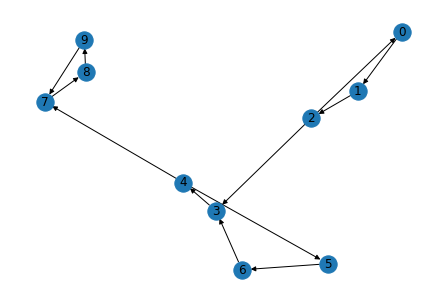

In [1]:
import numpy as np
import networkx as nx

J = nx.DiGraph()

J.add_edge(0,1)
J.add_edge(1,2)
J.add_edge(2,0)
J.add_edge(2,3)
J.add_edge(3,4)
J.add_edge(4,5)
J.add_edge(6,3)
J.add_edge(5,6)
J.add_edge(4,7)
J.add_edge(7,8)
J.add_edge(8,9)
J.add_edge(9,7)

flows = {}

flows[(0,1)] = 10.
flows[(1,2)] = 10
flows[(2,0)] = 10.
flows[(2,3)] = 0.
flows[(3,4)] = 20.
flows[(4,5)] = 20.
flows[(6,3)] = 20
#flows[(6,4)] = 10.
flows[(5,6)] = 20.
flows[(4,7)] = 0
flows[(7,8)] = 30
flows[(8,9)] = 30
flows[(9,7)] = 30

np.random.seed(540)
nx.draw(J, with_labels=True)

In [2]:
from sensors import *

opt = choose_sensors(J, flows, flow_prediction, mse, 3)
opt

  0%|          | 0/3 [00:00<?, ?it/s]

[(9, 7), (3, 4), (0, 1)]

In [3]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt}))

2.082821407672434e-21

In [4]:
opt_lazy = choose_sensors(J, flows, flow_prediction, mse, lazy=True, k=3)
opt_lazy

  0%|          | 0/3 [00:00<?, ?it/s]

[(9, 7), (3, 4), (0, 1)]

In [5]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt_lazy}))

2.082821407672434e-21

In [6]:
flow_prediction(J, {s : flows[s] for s in opt_lazy})

{(0, 1): 10.0,
 (1, 2): 10.000000000011017,
 (2, 0): 9.999999999968992,
 (2, 3): 6.298117583014573e-11,
 (3, 4): 20.0,
 (4, 5): 19.99999999993401,
 (4, 7): 2.6997959423624707e-11,
 (5, 6): 19.99999999991502,
 (6, 3): 19.99999999991601,
 (7, 8): 29.999999999988013,
 (8, 9): 29.999999999979003,
 (9, 7): 30}

In [7]:
mape(flows, flow_prediction(J, {s : flows[s] for s in opt_lazy}))

1.70500650635657e-09

In [ ]:
G = nx.path_graph(6)

eigs = np.linalg.eig(nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=nx.line_graph(G).nodes()).toarray())
order = np.argsort(eigs[0])

speeds = vect2dict(G, eigs[1][:,-1])
speeds

In [ ]:
speeds = {
    (0, 1): -20,
    (1, 2): -10,
    (2, 3): 0,
    (3, 4): 10,
    (4, 5): 20
}

In [ ]:
nx.draw(G, with_labels=True, edge_color=[speeds[e] for e in G.edges()], node_color="white")

In [ ]:
def synthetic_speeds(G):
    eigs = np.linalg.eig(nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=nx.line_graph(G).nodes()).toarray())
    order = np.argsort(eigs[0])
    
    vals = eigs[1][:,-1]
    speeds = {}
    for i, v in enumerate(nx.line_graph(G).nodes()):
        speeds[v] = vals[i]
    return speeds

speeds = synthetic_speeds(G)
nx.draw(G, with_labels=True, edge_color=[speeds[e] for e in G.edges()], node_color="white")

In [ ]:
opt_lazy = choose_sensors(G, speeds, speed_prediction, mse, debug=True, k=5)

In [ ]:
mse(speeds, speed_prediction_iterative(G, {s : speeds[s] for s in opt_lazy[:5]}))

In [ ]:
def speed_prediction_iterative(G, labeled_flows, iters=1000, P=None):
    x = dict2vect(G, labeled_flows)
    G_line = nx.line_graph(G)
    
    fixed = []
    for i, e in enumerate(G_line.nodes()):
        if e in labeled_flows:
            fixed.append((i,e))
    
    if P == None:
        A = nx.adjacency_matrix(G_line)

        D = np.zeros((G_line.number_of_nodes(), G_line.number_of_nodes()))
        for i, e in enumerate(G_line.nodes()):
            D[i][i] = G_line.degree[e]
    
        P = np.linalg.inv(D) @ A
    
    for i in range(iters):
        x = P @ x
        for j, e in fixed:
            x[j] = labeled_flows[e]
    
    return vect2dict(G, x)